In [2]:
import os
import argparse
import time
import numpy as np
import torch
import torch . nn as nn
import torch . optim as optim
from torch . nn import functional as F
import matplotlib . pyplot as plt
import seaborn as sns
from torchdiffeq import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Using device: cpu
Starting training...
Epoch 10/200, Loss: 0.037966, Time: 140.11s
Epoch 20/200, Loss: 0.028955, Time: 128.00s
Epoch 30/200, Loss: 0.026292, Time: 132.73s
Epoch 40/200, Loss: 0.026080, Time: 123.08s
Epoch 50/200, Loss: 0.024972, Time: 118.22s
Epoch 60/200, Loss: 0.024537, Time: 116.29s
Epoch 70/200, Loss: 0.024789, Time: 86.83s
Epoch 80/200, Loss: 0.024254, Time: 89.90s
Epoch 90/200, Loss: 0.025158, Time: 96.41s
Epoch 100/200, Loss: 0.025925, Time: 119.97s
Epoch 110/200, Loss: 0.023841, Time: 131.41s
Epoch 120/200, Loss: 0.024244, Time: 112.28s
Epoch 130/200, Loss: 0.023845, Time: 112.89s
Epoch 140/200, Loss: 0.024296, Time: 130.95s
Epoch 150/200, Loss: 0.023568, Time: 114.47s
Epoch 160/200, Loss: 0.023666, Time: 144.74s
Epoch 170/200, Loss: 0.024246, Time: 117.49s
Epoch 180/200, Loss: 0.023461, Time: 126.26s
Epoch 190/200, Loss: 0.024527, Time: 116.61s
Epoch 200/200, Loss: 0.023509, Time: 115.52s
Training completed. Total time: 33350.33s


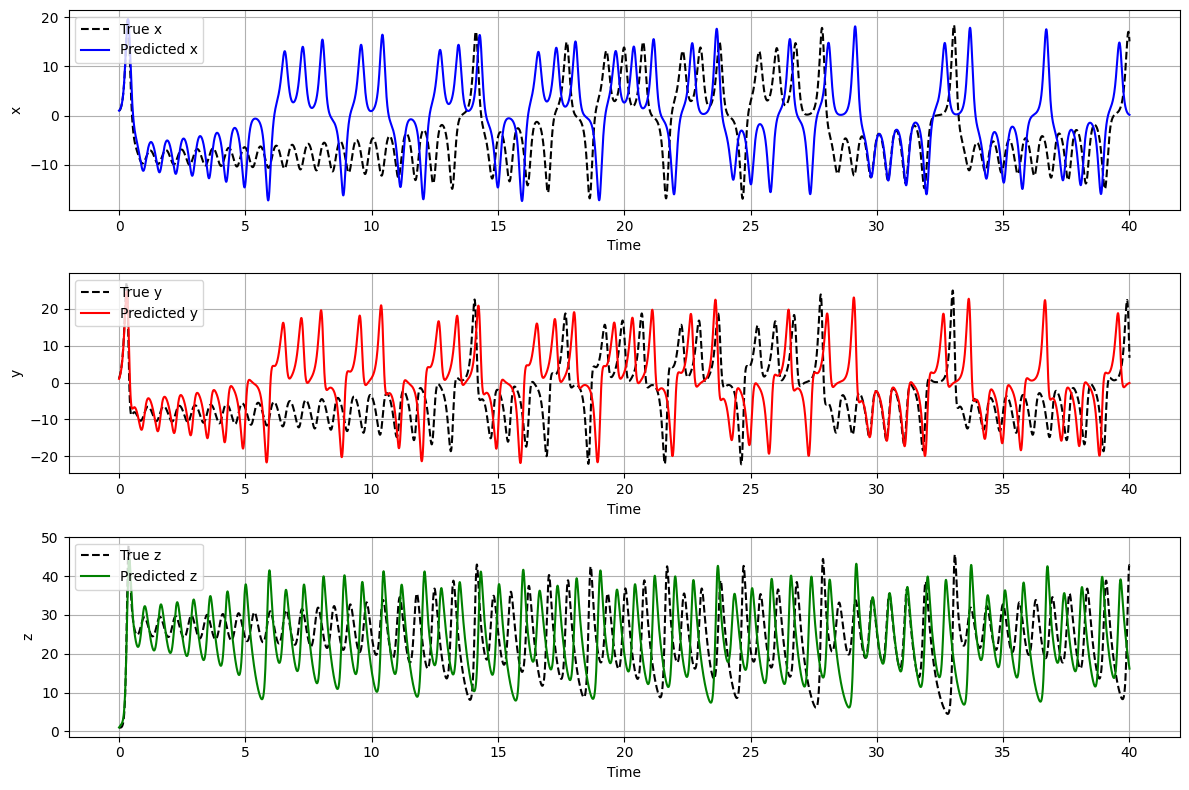

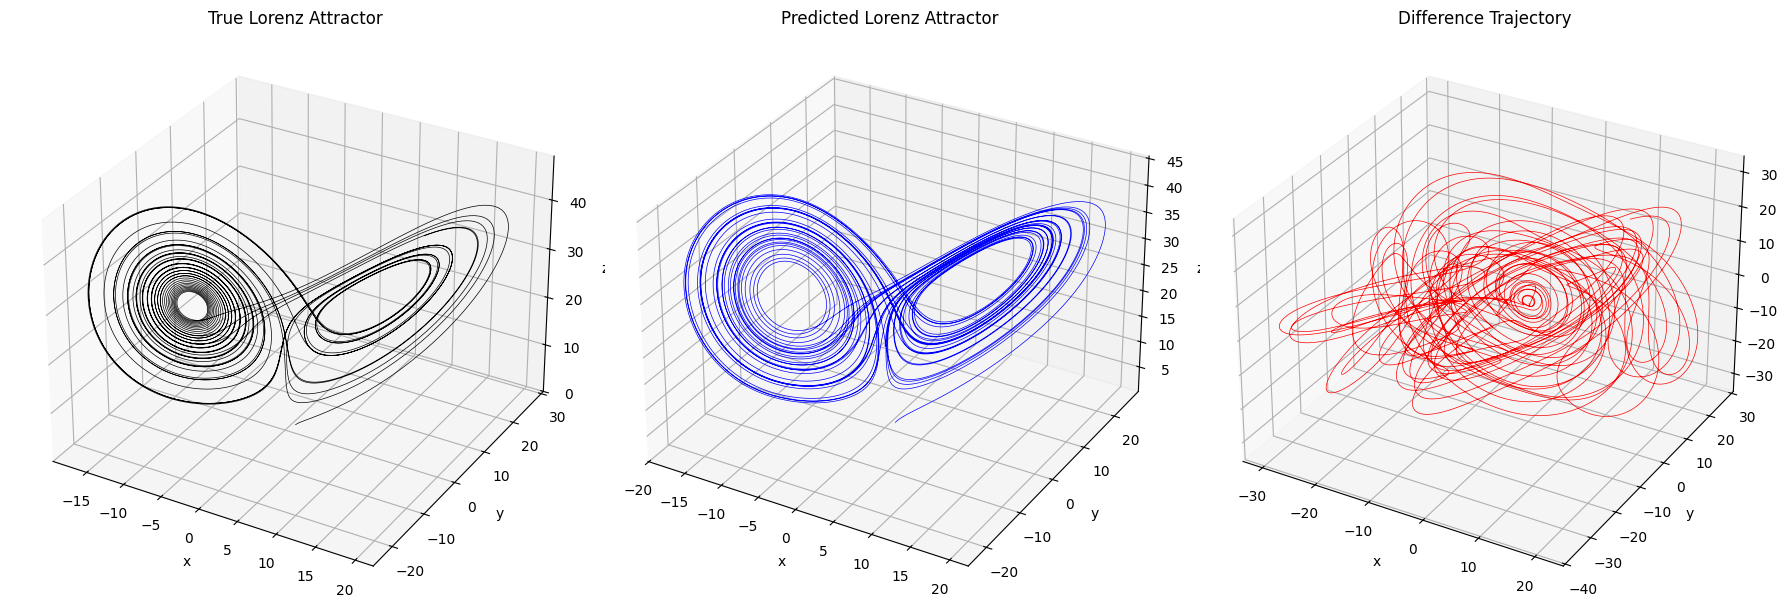

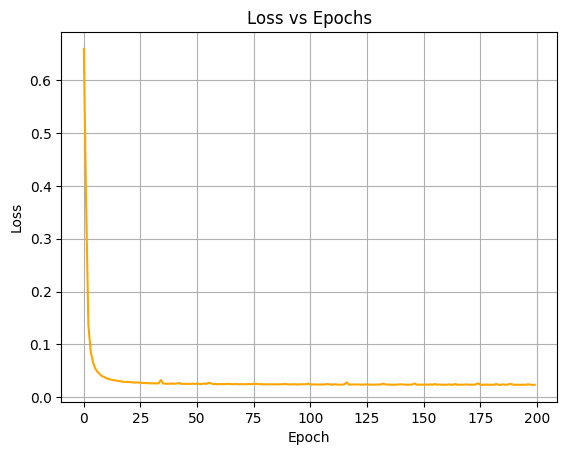

In [3]:
# For 3D plotting
from mpl_toolkits.mplot3d import Axes3D



# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device to GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Generate Lorenz data
def generate_lorenz_data(t, initial_state, sigma=10.0, rho=28.0, beta=8.0/3.0, noise_scale=0.0):
    from scipy.integrate import odeint as scipy_odeint

    def lorenz_system(state, t0):
        x, y, z = state
        dx_dt = sigma * (y - x)
        dy_dt = x * (rho - z) - y
        dz_dt = x * y - beta * z
        return [dx_dt, dy_dt, dz_dt]

    states = scipy_odeint(lorenz_system, initial_state, t)
    states = torch.tensor(states, dtype=torch.float32).to(device)

    # Add noise
    if noise_scale > 0:
        noise = noise_scale * torch.randn_like(states)
        states += noise
    return states

# Define the neural network ODE function
class ODEFunc(nn.Module):
    def __init__(self, hidden_dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 3)
        ).to(device)

    def forward(self, t, y):
        return self.net(y)

# Function to create sequences
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        sequences.append(seq)
    return torch.stack(sequences)

# Training function
def train_neural_ode(func, train_loader, t, epochs=200, print_every=10, patience=20, l2_lambda=1e-4):
    print("Starting training...")
    optimizer = optim.Adam(func.parameters(), lr=0.001)
    loss_func = nn.MSELoss()
    best_loss = float('inf')
    patience_counter = 0
    start_time = time.time()

    losses = []

    func.train()  # Set the model to training mode

    for epoch in range(epochs):
        epoch_start = time.time()
        epoch_loss = 0.0

        for batch in train_loader:
            batch_sequences = batch[0].to(device)  # Move batch to GPU
            y0 = batch_sequences[:, 0, :]  # Initial states: (batch_size, features)
            t_batch = t[:seq_length] - t[0]  # Time points for the sequences

            optimizer.zero_grad()

            # Predicted trajectories
            pred_y = odeint(func, y0, t_batch)  # Shape: (seq_length, batch_size, features)
            pred_y = pred_y.permute(1, 0, 2)    # Reshape to (batch_size, seq_length, features)

            # Compute loss
            loss = loss_func(pred_y, batch_sequences)

            # L2 regularization
            l2_norm = sum(p.pow(2.0).sum() for p in func.parameters())
            loss = loss + l2_lambda * l2_norm

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        epoch_loss /= len(train_loader)
        losses.append(epoch_loss)

        epoch_duration = time.time() - epoch_start

        if (epoch + 1) % print_every == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.6f}, Time: {epoch_duration:.2f}s")

        # Early stopping
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    total_time = time.time() - start_time
    print(f"Training completed. Total time: {total_time:.2f}s")

    return losses

# Visualization functions
def plot_trajectories(t, true_states, pred_states):
    plt.figure(figsize=(12, 8))

    # Plot x-coordinate
    plt.subplot(3, 1, 1)
    plt.plot(t, true_states[:, 0], label='True x', linestyle='--', color='black')
    plt.plot(t, pred_states[:, 0], label='Predicted x', color='blue')
    plt.xlabel('Time')
    plt.ylabel('x')
    plt.legend()
    plt.grid(True)

    # Plot y-coordinate
    plt.subplot(3, 1, 2)
    plt.plot(t, true_states[:, 1], label='True y', linestyle='--', color='black')
    plt.plot(t, pred_states[:, 1], label='Predicted y', color='red')
    plt.xlabel('Time')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)

    # Plot z-coordinate
    plt.subplot(3, 1, 3)
    plt.plot(t, true_states[:, 2], label='True z', linestyle='--', color='black')
    plt.plot(t, pred_states[:, 2], label='Predicted z', color='green')
    plt.xlabel('Time')
    plt.ylabel('z')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_lorenz_attractor(true_states, pred_states):
    fig = plt.figure(figsize=(18, 6))

    ax = fig.add_subplot(131, projection='3d')
    ax.plot(true_states[:, 0], true_states[:, 1], true_states[:, 2], color='black', linewidth=0.5)
    ax.set_title('True Lorenz Attractor')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    ax_pred = fig.add_subplot(132, projection='3d')
    ax_pred.plot(pred_states[:, 0], pred_states[:, 1], pred_states[:, 2], color='blue', linewidth=0.5)
    ax_pred.set_title('Predicted Lorenz Attractor')
    ax_pred.set_xlabel('x')
    ax_pred.set_ylabel('y')
    ax_pred.set_zlabel('z')

    ax_diff = fig.add_subplot(133, projection='3d')
    ax_diff.plot(true_states[:, 0] - pred_states[:, 0],
                 true_states[:, 1] - pred_states[:, 1],
                 true_states[:, 2] - pred_states[:, 2],
                 color='red', linewidth=0.5)
    ax_diff.set_title('Difference Trajectory')
    ax_diff.set_xlabel('x')
    ax_diff.set_ylabel('y')
    ax_diff.set_zlabel('z')

    plt.tight_layout()
    plt.show()

def plot_losses(losses):
    plt.figure()
    plt.plot(range(len(losses)), losses, color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs')
    plt.grid(True)
    plt.show()

# Main script
if __name__ == "__main__":
    # Generate data with extended time range
    t = torch.linspace(0., 40., 10000).to(device)  # Extended time range
    initial_state = torch.tensor([1.0, 1.0, 1.0], device=device)
    data = generate_lorenz_data(t.cpu().numpy(), initial_state.cpu().numpy(), noise_scale=0.0)
    data = data.to(device)

    # Normalize data
    data_mean = data.mean(dim=0)
    data_std = data.std(dim=0)
    data_norm = (data - data_mean) / data_std

    # Create sequences with increased sequence length
    seq_length = 100  # Increased sequence length
    sequences = create_sequences(data_norm, seq_length)

    # Create DataLoader
    batch_size = 64  # Adjusted batch size
    train_dataset = torch.utils.data.TensorDataset(sequences)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Time points for sequences
    t_seq = t[:seq_length] - t[0]

    # Initialize and train the model with more epochs
    func = ODEFunc(hidden_dim=128).to(device)  # Increased hidden dimension
    losses = train_neural_ode(
        func, train_loader, t_seq, epochs=200, print_every=10, patience=30, l2_lambda=1e-4
    )

    # Generate predictions for visualization
    func.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        y0 = data_norm[0].unsqueeze(0).to(device)
        pred_y = odeint(func, y0, t - t[0])
        pred_y = pred_y.squeeze().cpu().numpy()  # Move to CPU and convert to NumPy
        pred_y = pred_y * data_std.cpu().numpy() + data_mean.cpu().numpy()  # Denormalize

    # Rescale data
    data_rescaled = data.cpu().numpy()

    # Plot results
    plot_trajectories(t.cpu().numpy(), data_rescaled, pred_y)
    plot_lorenz_attractor(data_rescaled, pred_y)
    plot_losses(losses)